<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/kl.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(loo_notebook)=
# Validazione Incrociata Leave-One-Out

```{admonition} Obiettivi di apprendimento
Dopo aver completato questo capitolo, acquisirete le competenze per:

- comprendere il concetto di Validazione Incrociata Leave-One-Out;
- calcolare LOO-CV usando PyC;
- usare LOO-CV nel confronto tra modelli;
- comprendere il concetto di valore diagnostico Pareto $k$;
- calcolare i valori diagnostici Pareto $k$ con PyMC.
```

In questo capitolo, ci addentreremo nel contesto della stima dell'Expected Log Predictive Density (ELPD), un parametro fondamentale per valutare l'efficacia di un modello statistico nel fare previsioni accurate. La ELPD si concentra sulla qualità delle previsioni di un modello, considerando come esso si comporta di fronte a nuovi dati, non ancora osservati. Questo aspetto è cruciale perché un modello che si adatta perfettamente ai dati passati potrebbe non essere necessariamente efficace nel prevedere futuri eventi o osservazioni.

Tra i vari metodi disponibili per stimare la ELPD, uno dei più affidabili e comunemente utilizzati è la validazione incrociata Leave-One-Out (LOO-CV). Questa tecnica offre un modo sistematico e rigoroso per valutare la capacità predittiva di un modello statistico. La LOO-CV si distingue per il suo approccio unico: anziché utilizzare l'intero set di dati per adattare il modello e valutarne le prestazioni, rimuove una osservazione alla volta dal set di dati, adatta il modello ai dati rimanenti, e poi valuta la sua capacità di prevedere l'osservazione esclusa. Questo processo viene ripetuto per ogni osservazione all'interno del set di dati, fornendo una valutazione comprensiva e dettagliata della capacità del modello di generalizzare oltre i dati a sua disposizione.

La LOO-CV è particolarmente utile nei contesti in cui i dati sono limitati o quando ogni osservazione è preziosa per la comprensione del fenomeno sotto indagine. Attraverso questo metodo, possiamo acquisire una visione più chiara e realistica della capacità predittiva del modello, che è fondamentale per applicazioni pratiche e decisioni basate su dati.

In questo capitolo, esploreremo in dettaglio la metodologia della LOO-CV, discutendo come può essere implementata per stimare la ELPD. Analizzeremo anche i suoi punti di forza e le sfide associate, fornendo esempi pratici e linee guida su come utilizzare efficacemente questo metodo nella valutazione dei modelli statistici. Questa discussione sarà arricchita da un'analisi critica dei risultati ottenuti attraverso la LOO-CV, consentendoci di comprendere meglio come questo approccio possa essere sfruttato per ottimizzare le prestazioni predittive dei modelli statistici in vari contesti.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
from scipy.stats import beta
from scipy.integrate import quad
import arviz as az

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

## Validazione Incrociata Leave-One-Out per la Stima dell'ELPD

Per stimare l'Expected Log Predictive Density (ELPD), un approccio efficace e consolidato è rappresentato dalla validazione incrociata Leave-One-Out (LOO-CV). Questo metodo permette di valutare con precisione la capacità di un modello di fare previsioni accurate. La LOO-CV si articola in una serie di passaggi sistematici:

1. **Esclusione di un'osservazione**: Inizialmente, si rimuove una singola osservazione dal set di dati.
2. **Adattamento del Modello ai Dati Residui**: Successivamente, il modello viene adattato utilizzando il set di dati ridotto, escludendo l'osservazione rimossa.
3. **Valutazione delle Previsioni del Modello**: Si procede poi a valutare la capacità del modello di prevedere l'osservazione che è stata esclusa.
4. **Iterazione per Ogni Osservazione e Calcolo della Media**: Questo processo viene ripetuto per ogni singola osservazione nel set di dati. Per ciascuna iterazione, si calcola il valore logaritmico predittivo e si ottiene alla fine una media di questi valori, che fornisce una stima complessiva dell'ELPD attraverso la LOO-CV.

La LOO-CV si distacca dalla semplice media della densità logaritmica predittiva (LPD) per il suo approccio unico alla valutazione:

- **Media della LPD**: Questo metodo valuta la capacità predittiva del modello sull'intero set di dati, basandosi sulla probabilità complessiva assegnata dal modello ai dati osservati.
  
- **LOO-CV**: A differenza della media della LPD, la LOO-CV fornisce una misura più dettagliata e generalizzabile della capacità predittiva del modello. Attraverso l'esclusione e la valutazione di ciascuna osservazione individualmente, la LOO-CV verifica la robustezza e la capacità di generalizzazione del modello, offrendo una stima realistica di come potrebbe comportarsi nel prevedere nuovi dati.

In conclusione, mentre la media della LPD offre una valutazione generale basata sull'intero set di dati, la LOO-CV fornisce una visione più approfondita e generalizzabile, valutando la capacità del modello di adattarsi e prevedere con precisione nuovi dati. Questo approccio rende la LOO-CV uno strumento prezioso per una valutazione accurata delle prestazioni predittive dei modelli statistici.

## Un Esempio Empirico

Esaminiamo il calcolo di LOO-CV per i dati dell'esempio usato nel capitolo precedente. Iniziamo a calcolare la log-verosimiglianza.

In [11]:
SEED = 42  # Scegli un valore per il seed
np.random.seed(SEED)
data = np.random.normal(loc=5, scale=2, size=100)
print(data)

[ 5.99342831  4.7234714   6.29537708  8.04605971  4.53169325  4.53172609
  8.15842563  6.53486946  4.06105123  6.08512009  4.07316461  4.06854049
  5.48392454  1.17343951  1.55016433  3.87542494  2.97433776  5.62849467
  3.18395185  2.1753926   7.93129754  4.5484474   5.13505641  2.15050363
  3.91123455  5.22184518  2.69801285  5.75139604  3.79872262  4.4166125
  3.79658678  8.70455637  4.97300555  2.88457814  6.64508982  2.5583127
  5.41772719  1.08065975  2.3436279   5.39372247  6.47693316  5.34273656
  4.76870344  4.39779261  2.04295602  3.56031158  4.07872246  7.11424445
  5.68723658  1.47391969  5.64816794  4.22983544  3.646156    6.22335258
  7.06199904  6.86256024  3.32156495  4.38157525  5.66252686  6.95109025
  4.04165152  4.62868205  2.78733005  2.60758675  6.62505164  7.71248006
  4.85597976  7.0070658   5.72327205  3.70976049  5.72279121  8.07607313
  4.92834792  8.12928731 -0.23949021  6.64380501  5.17409414  4.4019853
  5.18352155  1.02486217  4.56065622  5.71422514  7.95

In [12]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data)
    # Sampling from the posterior
    trace = pm.sampling_jax.sample_numpyro_nuts(1000)
    # Generating posterior predictive samples
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["y"]
    )

Compiling...
Compilation time = 0:00:00.352652
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1585.27it/s]
Sampling time = 0:00:01.346116
Transforming variables...
Transformation time = 0:00:00.039550
Sampling: [y]


In [13]:
with model:
    pm.compute_log_likelihood(trace)

Ora usiamo la funzione `loo()` del pacchetto Arviz per calcolare LOO-CV:

In [14]:
loo_result = az.loo(trace, pointwise=True)
print(loo_result)

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -203.06     6.84
p_loo        1.89        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Il valore di `overall_mean_log_density` che abbiamo calcolato precedentemente, pari a -2.0209, non è direttamente paragonabile al valore di `elpd_loo`, che è di -203.06, a causa delle differenze significative nelle loro scale e nei metodi di calcolo. Questa distinzione è importante da comprendere per una corretta interpretazione dei risultati.

Per iniziare, `overall_mean_log_density` rappresenta la media aritmetica dei logaritmi delle densità predittive per ogni singola osservazione nel set di dati. Questo valore si concentra su una stima media dell'adattamento del modello a ciascuna osservazione individualmente.

D'altra parte, `elpd_loo`, ovvero l'Expected Log Predictive Density calcolato tramite la validazione incrociata Leave-One-Out, fornisce una stima globale dell'adattamento del modello. Questo valore tiene conto non solo dell'adattamento del modello ai dati esistenti, ma anche della sua capacità di generalizzare e fare previsioni accurate su nuove osservazioni. Il calcolo di `elpd_loo` incorpora un'analisi più complessa, considerando l'effetto di rimuovere ogni osservazione dal set di dati e valutando la capacità predittiva del modello in queste condizioni.

Nonostante queste differenze, in entrambi i casi valori più elevati (cioè meno negativi) sono indicatori di prestazioni migliori. Tuttavia, a causa delle differenze nei loro metodi di calcolo e nell'interpretazione, non è possibile trasformare direttamente il valore di `overall_mean_log_density` in `elpd_loo` o viceversa. Sono due misure distinte che offrono prospettive diverse sull'adattamento e le capacità predittive del modello, e dovrebbero essere considerate complementari piuttosto che direttamente comparabili.

In conclusione, mentre la media della LPD fornisce una valutazione della performance del modello basata sull'intero set di dati, la LOO-CV offre una prospettiva più rigorosa e generalizzabile sulla capacità predittiva del modello. È importante notare che strumenti come PyMC e Arviz facilitano il calcolo della LOO-CV, specialmente in scenari che coinvolgono l'utilizzo di tecniche di campionamento MCMC. Questi strumenti possono semplificare notevolmente l'analisi in contesti di statistica bayesiana.

## Valori Diagnostici Pareto $k$ in LOO-CV

I valori diagnostici Pareto $k$ giocano un ruolo cruciale nell'analizzare l'affidabilità della stima dell'ELPD ottenuta tramite la LOO-CV. Questi valori sono indicatori chiave della precisione con cui la LOO-CV approssima l'ELPD. In altre parole, il valore Pareto $k$ ci aiuta a comprendere quanto la stima dell'ELPD, ottenuta tramite il processo LOO-CV, sia vicina al valore reale dell'ELPD che avremmo ottenuto se avessimo potuto calcolarlo direttamente senza approssimazioni.

Quando utilizziamo la LOO-CV, stiamo cercando di stimare come un modello si comporterebbe nel fare previsioni su nuove osservazioni, basandoci sui dati esistenti. Il valore Pareto $k$ fornisce un'indicazione di quanto possiamo fidarci di questa stima. Valori di $k$ inferiori indicano una maggiore affidabilità nella stima dell'ELPD tramite la LOO-CV, mentre valori più alti suggeriscono che la stima potrebbe essere meno precisa a causa di problematiche nei dati o nel modello stesso.

I valori diagnostici Pareto $k$ si interpretano nel modo seguente:

- **$k < 0.5$**: Indica un'ottima approssimazione. L'errore associato all'approssimazione LOO-CV è trascurabile.

- **$0.5 \leq k < 0.7$**: Qui l'approssimazione è ancora buona, ma con qualche riserva. Potrebbe essere utile un'analisi più dettagliata del modello e dei dati.

- **$0.7 \leq k < 1$**: La qualità dell'approssimazione inizia a essere mediocre. I risultati del LOO-CV potrebbero non essere del tutto affidabili, suggerendo la necessità di valutare alternative o di apportare modifiche al modello.

- **$k \geq 1$**: Un valore di $k$ così elevato segnala un'approssimazione inadeguata. I risultati del LOO-CV sono probabilmente poco affidabili e si dovrebbe prestare attenzione a possibili problemi nel modello o nel metodo di approssimazione utilizzato.

Il valore diagnostico Pareto $k$ si basa sulla distribuzione di Pareto e valuta le differenze di log-verosimiglianza (tra la log-verosimiglianza del punto dati escluso e quella calcolata sull'intero dataset). Valori elevati di $k$ suggeriscono code più pesanti del previsto nella distribuzione delle differenze, indicando possibili imprecisioni nell'approssimazione LOO-CV.

In breve, il valore di Pareto $k$ fornisce un'indicazione chiara sull'affidabilità dell'approssimazione LOO-CV e aiuta a identificare potenziali problemi nel modello o nella metodologia di validazione.

## Il Ruolo dell'ELPD nella Valutazione Comparativa dei Modelli

L'ELPD è fondamentale per il confronto di diversi modelli statistici. Utilizzando metodologie come la LOO-CV per stimare l'ELPD, possiamo ottenere una valutazione oggettiva dell'adeguatezza di ciascun modello rispetto ai dati. Questo è cruciale nella scelta del modello più adatto tra diverse alternative o nel decidere se un modello più complesso offre un miglior adattamento rispetto a uno più semplice.

In conclusione, l'ELPD agisce come un indicatore affidabile della capacità predittiva di un modello. La LOO-CV, a sua volta, fornisce un modo efficace per stimare questa metrica, permettendo analisi precise e robuste delle prestazioni di diversi modelli. L'automazione di queste procedure di valutazione attraverso software come PyMC e Arviz rende l'approccio ancora più pratico e accessibile, consolidandone il ruolo come strumento essenziale per la selezione e la validazione di modelli statistici.

### Simulazione

Per illustrare il confronto tra modelli utilizzando la LOO-CV, procediamo con una simulazione. Genereremo dati sintetici in cui esiste una relazione lineare tra le variabili $x$ e $y$. In questo scenario, potremmo essere interessati a confrontare un modello lineare con un modello più semplice, che considera solo il termine di intercetta. Utilizzeremo la LOO-CV per stabilire quale dei due modelli si adatta meglio ai dati in questione. La stima dell'ELPD servirà come criterio quantitativo per orientare questa scelta di modello.

In [57]:
# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 10, 100)
y_true = 3 + 2 * X
y_obs = y_true + np.random.normal(scale=3, size=100)

Adattiamo ai dati un modello che rispecchia il vero meccanismo generativo dei dati.

Si noti che, per calcolare LOO e WAIC, ArviZ ha bisogno di accedere alla log-likelihood per ogni campione posteriore. Possiamo trovarla tramite `compute_log_likelihood()`. In alternativa, possiamo passare `idata_kwargs={"log_likelihood": True}` a `sample()` per farla calcolare automaticamente alla fine del campionamento.

In [58]:
# Linear model
with pm.Model() as linear_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=10)
    mu = alpha + beta * X
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=y_obs)

In [59]:
with linear_model:
    linear_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time = 0:00:06.769447
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1317.06it/s]
Sampling time = 0:00:02.015048
Transforming variables...
Transformation time = 0:00:00.076807
Computing Log Likelihood...
Log Likelihood time = 0:00:00.131425


Adattiamo ora un secondo modello che non tiene conto della relazione lineare tra x e y.

In [60]:
# Intercept model
with pm.Model() as intercept_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    mu = alpha 
    y = pm.Normal("y", mu=mu, observed=y_obs)

In [61]:
with intercept_model:
    intercept_trace = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time = 0:00:03.437606
Sampling...
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1984.36it/s]
Sampling time = 0:00:01.062643
Transforming variables...
Transformation time = 0:00:00.030917
Computing Log Likelihood...
Log Likelihood time = 0:00:00.069106


Troviamo ora elpd con il metodo LOO.

In [62]:
linear_loo = az.loo(linear_trace)
linear_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -244.53     6.90
p_loo        2.83        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [63]:
intercept_loo = az.loo(intercept_trace)
intercept_loo

Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2252.81   195.97
p_loo       44.04        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Infine, calcoliamo `eldp_diff`. L'incertezza di questa quantità è espressa dall'errore standard. Se il rapporto tra `eldp_diff` e il suo errore standard è almeno uguale a 2, allora possiamo concludere che vi è una differenza credibile tra di due modelli.

In [64]:
df_comp_loo = az.compare({"linear_model": linear_trace, "intercept_model": intercept_trace})
df_comp_loo

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear_model,0,-244.534059,2.825462,0.000000,1.0,6.901659,0.000000,False,log
intercept_model,1,-2252.811522,44.044164,2008.277463,0.0,195.968814,195.623603,False,log


Nel caso presente, sappiamo che il modello che include una relazione lineare tra le due variabili è quello che rispecchia il modo in cui i dati sono stati generati. Infatti, troviamo che il rapporto tra `eldp_diff` e il suo errore standard è molto maggiore di 2, il che conferma che, per questi dati, il modello lineare è da preferire al modello che include solo l'intercetta.

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


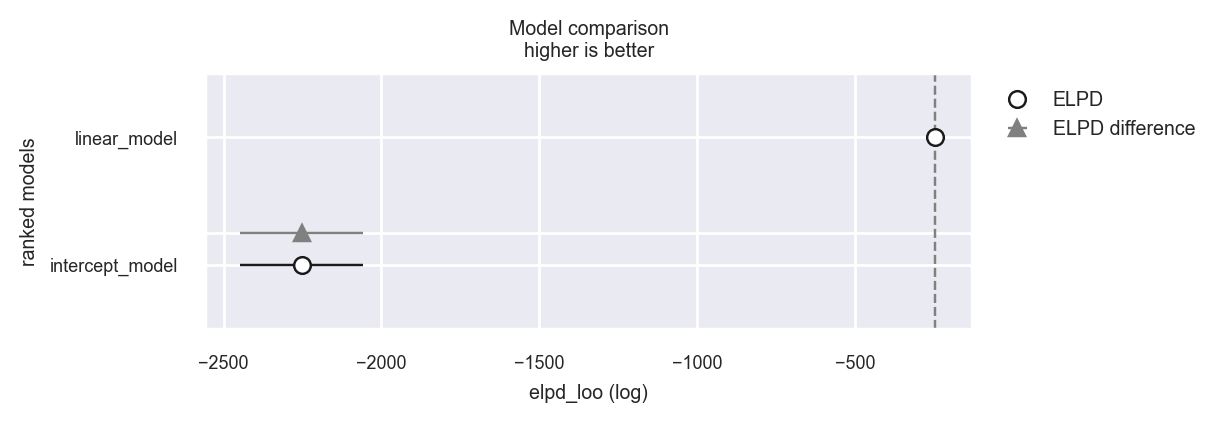

In [73]:
_ = az.plot_compare(df_comp_loo, insample_dev=False)

## Riflessioni Conclusive 

In questo capitolo, abbiamo approfondito il metodo della Validazione Incrociata Leave-One-Out (LOO-CV) come strumento efficace per stimare l'Expected Log Predictive Density (ELPD). Abbiamo illustrato in dettaglio come la LOO-CV possa essere applicata utilizzando il framework PyMC, evidenziando il suo ruolo cruciale nella pratica della modellazione statistica.

Un aspetto centrale che abbiamo esaminato è l'importanza della LOO-CV nel contesto del confronto tra diversi modelli statistici. Questo metodo non solo aiuta a valutare la capacità predittiva di un singolo modello, ma si rivela anche essenziale quando si tratta di selezionare il modello più adatto tra un insieme di alternative, fornendo una base di confronto oggettiva e affidabile.

Inoltre, abbiamo discusso il ruolo significativo dei valori diagnostici Pareto $k$ nell'interpretazione delle stime ottenute tramite LOO-CV. Abbiamo sottolineato come questi valori siano fondamentali per valutare l'affidabilità delle stime di ELPD derivate dalla LOO-CV, offrendo una misura della precisione e della robustezza di queste stime.

Nel complesso, attraverso questo capitolo, abbiamo mirato a fornire una comprensione completa di come la LOO-CV e i valori diagnostici Pareto $k$ siano impiegati per migliorare la precisione e l'affidabilità delle stime di ELPD, migliorando così la qualità e l'efficacia dei modelli statistici in vari contesti di ricerca e applicazione.

## Watermark

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jan 25 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

scipy      : 1.11.4
seaborn    : 0.13.0
matplotlib : 3.8.2
pandas     : 2.1.4
numpy      : 1.26.2
pymc       : 5.10.3
statsmodels: 0.14.1
arviz      : 0.17.0

Watermark: 2.4.3

